In [1]:
#importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [2]:
#model to run on cuda
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
df= pd.read_csv('/content/userrevfinaldoc.csv')

In [ ]:
df = pd.read_csv('/content/product1.csv', encoding='latin-1') # Try 'latin-1' encoding first

In [ ]:
df


In [ ]:
# keeping text cleaned text and review_rating of df and rest drop

df = df[['text','cleaned_text', 'review_rating']]
df.head()


In [ ]:
#convert positive to 1 and negative to 0

df['review_rating'] = df['review_rating'].apply(lambda x: 1 if x == 'positive' else 0)


In [ ]:
df['review_rating'].value_counts()


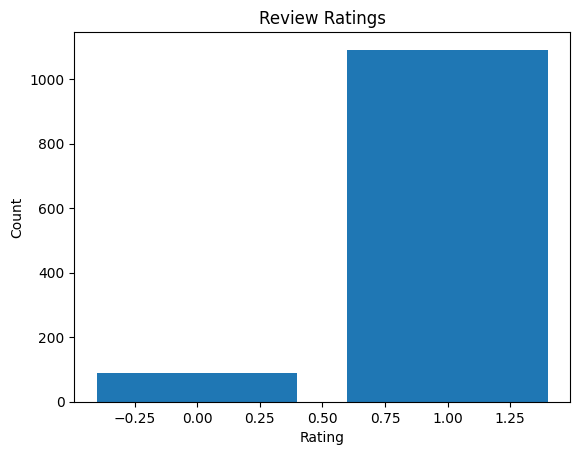

In [10]:
import matplotlib.pyplot as plt

# Get the counts of each review rating
rating_counts = df['review_rating'].value_counts()

# Get the names of each review rating
rating_names = rating_counts.index.to_list()

# Create a bar chart
plt.bar(rating_names, rating_counts)

# Add a title and labels
plt.title('Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Show the plot
plt.show()


In [11]:
from nltk.tokenize import word_tokenize


In [ ]:
#checking the word lenth using box plot
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="review_rating", grid=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
#setting parameter for tokeniztion
MAX_LEN = 100
TRAIN_BATCH_SIZE = 9
VALID_BATCH_SIZE = 9
EPOCHS = 5
LEARNING_RATE = 3e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
#defining class of tokenizer
class CustomDataset(Dataset):
    def __init__(self, Tokenizer, dataframe, max_len):
        self.tokenizer = Tokenizer
        self.data = dataframe
        self.text = dataframe.cleaned_text
        self.target = self.data.review_rating
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text = text,
            truncation = None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[index], dtype=torch.float)
        }

In [17]:
#split dataset df

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=32)


In [ ]:
test_df = test_df.reset_index(drop=True)
test_df

In [ ]:
train_df = train_df.reset_index(drop=True)
train_df

In [23]:
training = CustomDataset(tokenizer,train_df, MAX_LEN)
testing = CustomDataset(tokenizer, test_df, MAX_LEN)

In [24]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0}

In [25]:
training_loader = DataLoader(training, **train_params, drop_last = True)

testing_loader=DataLoader(testing, **test_params, drop_last = True)

In [26]:
def extract_hidden_states(batch):

    # Place model inputs on the GPU and convert them to Pytorch tensors.
    inputs = {k:torch.tensor(v).to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy().reshape(-1, 768)}

In [27]:
from transformers import AutoModel

In [ ]:
#model_ckpt = "distilbert-base-uncased"
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

#BERT MODEL CREATION

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.5)
        self.l3 = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

In [ ]:
#Introducing adaptive weights
import torch
from collections import Counter

class_counts = Counter(df['review_rating'])
print("Class Counts:", class_counts)

total_samples = len(df['review_rating'])
class_weights = {class_label: total_samples / count for class_label, count in class_counts.items()}
print("Class Weights:", class_weights)

weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
print("Weights Tensor:", weights_tensor)

In [31]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight = weights_tensor)(outputs, targets.long())

In [32]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [33]:
#training function defined
import torch.nn as nn
from tqdm import tqdm
def train(epoch):
    model.train()
    train_acc = 0
    for _,data in enumerate(tqdm(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

In [35]:
#test function defined
from torch import nn
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            predictions = torch.argmax(nn.functional.softmax(outputs, dim=1), dim = 1)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(predictions.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
#Classification Report
from sklearn.metrics import classification_report, confusion_matrix
for epoch in range(1,10):
    outputs, targets = validation(epoch)
    print(classification_report(outputs, targets))
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(targets, outputs)


cm

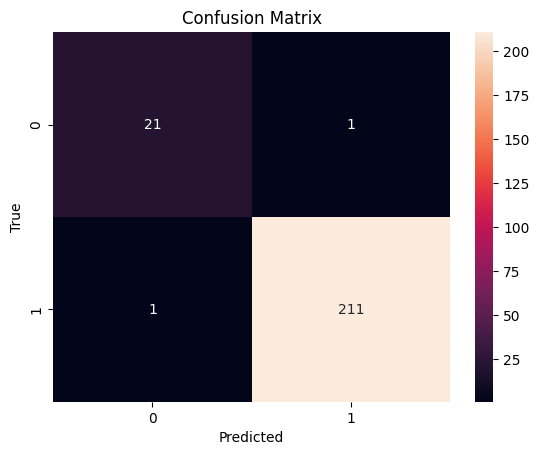

In [61]:

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [ ]:
#saving model
torch.save(model.state_dict(), "intel_model.pt")


#Using fine tuned BERT model to predict sentiment of technical review

In [ ]:
df1=pd.read_csv("/kaggle/input/topredict/tech2revclean.csv")

In [ ]:
#loading fine tuned BERT
import torch

# Path to your saved fine-tuned BERT model (replace with your actual path)
model_path = "/kaggle/input/model-intel/intel_model.pt"

# Load the fine-tuned model using torch.load
model = torch.load(model_path)



In [ ]:
import torch.nn as nn
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.5)
        self.l3 = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output
model = BERTClass()  # Replace with your model class
model.load_state_dict(torch.load("/kaggle/input/model-intel/intel_model.pt"))

In [ ]:
df1=pd.read_csv("/kaggle/input/intel-tech/tech2revclean.csv")

In [ ]:
df1['category']=''

In [ ]:
df2=pd.DataFrame()

##since technical dataset was too big we divided it in 200 datapoints gap


In [ ]:
df2 = df1[:200]
df3 = df1[200:400]
df4 = df1[400:600]
df5 = df1[600:800]
df6 = df1[800:1000]
df7 = df1[1000:1200]
df8 = df1[1200:1400]
df9 = df1[1400:1600]
df10 = df1[1600:1800]
df11 = df1[1800:2000]
df12 = df1[2000:2200]
df13 = df1[2200:2400]
df14 = df1[2400:2600]
df15 = df1[2600:2800]
df16 = df1[2800:3000]
df17 = df1[3000:3200]
df18 = df1[3200:3400]
df19 = df1[3400:3600]
df20 = df1[3600:3800]
df21 = df1[3800:4000]
df22 = df1[4000:]

In [ ]:
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df4.reset_index(drop=True, inplace=True)
df5.reset_index(drop=True, inplace=True)
df6.reset_index(drop=True, inplace=True)
df7.reset_index(drop=True, inplace=True)
df8.reset_index(drop=True, inplace=True)
df9.reset_index(drop=True, inplace=True)
df10.reset_index(drop=True, inplace=True)
df11.reset_index(drop=True, inplace=True)
df12.reset_index(drop=True, inplace=True)
df13.reset_index(drop=True, inplace=True)
df14.reset_index(drop=True, inplace=True)
df15.reset_index(drop=True, inplace=True)
df16.reset_index(drop=True, inplace=True)
df17.reset_index(drop=True, inplace=True)
df18.reset_index(drop=True, inplace=True)
df19.reset_index(drop=True, inplace=True)
df20.reset_index(drop=True, inplace=True)
df21.reset_index(drop=True, inplace=True)
df22.reset_index(drop=True, inplace=True)

In [ ]:
df1['category']=''

In [ ]:
df1

In [ ]:
len(df1)

In [ ]:
count=0

In [ ]:
df3

#saving the dataset with predicted sentiments


In [ ]:
df22.to_csv('ped21.csv', index=False)

In [ ]:
for index ,text in df22.iterrows() :
    df22['category'][index]=output1(text['cleaned_text'])

In [ ]:
#passing input to model for prediction
def output1(text):
    inputs = tokenizer.encode_plus(
    text=text,
    truncation=True,  # Truncate if it exceeds max_length
    add_special_tokens=True,
    max_length=100,  # Same max_len used in your dataset
    pad_to_max_length=True,
    return_token_type_ids=True)
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0)  # Add batch dimension
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0)
    with torch.no_grad():  # Disable gradient calculation for efficiency
        outputs = model(ids, mask, token_type_ids)
    predictions = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
    pred=(int)(predictions.cpu().detach().numpy())
    return(pred)

In [ ]:
df1.to_csv('predictionstech1.csv', index=False)